# การนำเข้าและการเตรียมข้อมูล

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

# โหลดข้อมูลจากไฟล์ .csv 

In [5]:
import pandas as pd

# ระบุชื่อไฟล์ .csv ของชุดข้อมูล A
file_path = 'dataset-a.csv'

# โหลดข้อมูลจากไฟล์ .csv
data_a = pd.read_csv(file_path)

# แสดงตัวอย่างข้อมูล (หากต้องการ)
print(data_a.head())

          y         x
0 -0.323298  0.548814
1  0.366986  0.715189
2  0.074002  0.602763
3 -0.199561  0.544883
4 -0.403890  0.423655


# การแบ่งชุดข้อมูล

In [6]:
# แบ่งชุดข้อมูลเป็น Train and Test
X = data_a[['x']].values
y = data_a['y'].values

# แบ่งชุดข้อมูลเป็นชุดการฝึก, ชุดการตรวจสอบ, และชุดทดสอบ
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)


# การใช้ Grid Search ในการค้นหาค่า p ที่เหมาะสมสำหรับ Polynomial Regression:

In [8]:
from sklearn.pipeline import Pipeline

# สร้าง Pipeline ประมวลผลที่รวม PolynomialFeatures และ LinearRegression
poly_reg = PolynomialFeatures()
poly_model = LinearRegression()
poly_pipeline = Pipeline([("polynomial_features", poly_reg), ("linear_regression", poly_model)])

# กำหนดช่วงของ p ที่ต้องการทดสอบ
param_grid_poly = {'polynomial_features__degree': list(range(1, 11))}

# ใช้ GridSearchCV เพื่อค้นหาค่า p ที่เหมาะสม
grid_search_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_poly.fit(x_train, y_train)

# แสดงค่า p ที่ดีที่สุด
print("Best p for Polynomial:", grid_search_poly.best_params_['polynomial_features__degree'])

Best p for Polynomial: 1


# กำหนดช่วงของ alpha และ gamma ที่จะถูกทดสอบใน Kernel Ridge Regression

In [9]:
# กำหนดช่วงของ alpha และ gamma ที่ต้องการทดสอบ
param_grid_radial = {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# สร้างโมเดล LBF ราเดียล
radial_model = KernelRidge(kernel='rbf')

# ใช้ GridSearchCV เพื่อค้นหาค่า alpha และ gamma ที่เหมาะสม
grid_search_radial = GridSearchCV(radial_model, param_grid_radial, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_radial.fit(x_train, y_train)

# แสดงค่า alpha และ gamma ที่ดีที่สุด
print("Best alpha for Radial:", grid_search_radial.best_params_['alpha'])
print("Best gamma for Radial:", grid_search_radial.best_params_['gamma'])


Best alpha for Radial: 1000.0
Best gamma for Radial: 0.001


# สร้างโมเดล Polynomial Regression โดยใช้ค่า p ที่ดีที่สุดที่ได้จากการทดลอง:

In [102]:
# สร้างโมเดล LBF โพลนอมิอล ด้วยค่า p ที่ดีที่สุด
best_p_poly = grid_search_poly.best_params_['polynomial_features__degree']
poly_reg = PolynomialFeatures(degree=best_p_poly)
poly_X_train = poly_reg.fit_transform(x_train) 
poly_X_val = poly_reg.transform(x_vali)  
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_poly = poly_model.predict(poly_X_val)

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_poly = mean_squared_error(y_vali, y_val_pred_poly)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Polynomial Model:", mse_val_poly)

Validation MSE for Polynomial Model: 0.11399859419252725


# สร้างโมเดล Radial Kernel Ridge Regression (ราเดียล) โดยใช้ค่า alpha และ gamma ที่ดีที่สุดที่ได้จากการทดลอง

In [103]:
# สร้างโมเดล LBF ราเดียล ด้วยค่า alpha และ gamma ที่ดีที่สุด
best_alpha_radial = grid_search_radial.best_params_['alpha']
best_gamma_radial = grid_search_radial.best_params_['gamma']
radial_model = KernelRidge(kernel='rbf', alpha=best_alpha_radial, gamma=best_gamma_radial)
radial_model.fit(x_train, y_train)  # แก้ชื่อตัวแปร X_train เป็น x_train

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_radial = radial_model.predict(x_vali)  

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_radial = mean_squared_error(y_vali, y_val_pred_radial)  
print("Validation MSE for Radial Model:", mse_val_radial)

Validation MSE for Radial Model: 1.0512604413315876


# สร้างกราฟการกระจายตัว (Scatter Plot)

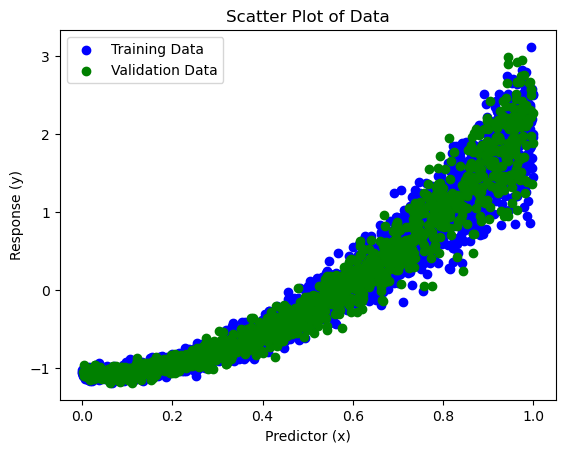

In [104]:
import matplotlib.pyplot as plt

# พล็อตกราฟการกระจายตัวของข้อมูล
plt.scatter(x_train, y_train, label='Training Data', color='blue')
plt.scatter(x_vali, y_vali, label='Validation Data', color='green')
plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.legend()
plt.title('Scatter Plot of Data')
plt.show()

# การนำเข้าและการเตรียมข้อมูลของชุดข้อมูล B

In [54]:
import pandas as pd

# ระบุชื่อไฟล์ .csv ของชุดข้อมูล B
file_path = 'dataset-b.csv'

# โหลดข้อมูลจากไฟล์ .csv
data_a = pd.read_csv(file_path)

# แสดงตัวอย่างข้อมูล (หากต้องการ)
print(data_a.head())

          y         x
0  1.134048  0.127802
1 -0.927377  0.607379
2  0.138384  0.009404
3 -0.904224  0.741701
4  0.732353  0.387152


# การแบ่งชุดข้อมูล

In [56]:
# แบ่งชุดข้อมูลเป็นชุดการฝึกและชุดการตรวจสอบ
X = data_a[['x']].values
y = data_a['y'].values

# แบ่งชุดข้อมูลเป็นชุดการฝึก, ชุดการตรวจสอบ, และชุดทดสอบ
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)


# การใช้ Grid Search ในการค้นหาค่า p ที่เหมาะสมสำหรับ Polynomial Regression:# 

In [58]:
from sklearn.pipeline import Pipeline

# สร้างท่อการประมวลผลที่รวม PolynomialFeatures และ LinearRegression
poly_reg = PolynomialFeatures()
poly_model = LinearRegression()
poly_pipeline = Pipeline([("polynomial_features", poly_reg), ("linear_regression", poly_model)])

# กำหนดช่วงของ p ที่ต้องการทดสอบ
param_grid_poly = {'polynomial_features__degree': list(range(1, 11))}

# ใช้ GridSearchCV เพื่อค้นหาค่า p ที่เหมาะสม
grid_search_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_poly.fit(x_train, y_train)

# แสดงค่า p ที่ดีที่สุด
print("Best p for Polynomial:", grid_search_poly.best_params_['polynomial_features__degree'])

Best p for Polynomial: 2


# กำหนดช่วงของ alpha และ gamma ที่จะถูกทดสอบใน Kernel Ridge Regression

In [18]:
# กำหนดช่วงของ alpha และ gamma ที่ต้องการทดสอบ
param_grid_radial = {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# สร้างโมเดล LBF ราเดียล
radial_model = KernelRidge(kernel='rbf')

# ใช้ GridSearchCV เพื่อค้นหาค่า alpha และ gamma ที่เหมาะสม
grid_search_radial = GridSearchCV(radial_model, param_grid_radial, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_radial.fit(X_train, y_train)

# แสดงค่า alpha และ gamma ที่ดีที่สุด
print("Best alpha for Radial:", grid_search_radial.best_params_['alpha'])
print("Best gamma for Radial:", grid_search_radial.best_params_['gamma'])


Best alpha for Radial: 1000.0
Best gamma for Radial: 0.001


# สร้างโมเดล Polynomial Regression โดยใช้ค่า p ที่ดีที่สุดที่ได้จากการทดลอง:

In [61]:
# สร้างโมเดลด้วยค่า p ที่ดีที่สุด
best_p_poly = grid_search_poly.best_params_['polynomial_features__degree']
poly_reg = PolynomialFeatures(degree=best_p_poly)
poly_X_train = poly_reg.fit_transform(x_train)  
poly_X_val = poly_reg.transform(x_vali)  
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_poly = poly_model.predict(poly_X_val)

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_poly = mean_squared_error(y_vali, y_val_pred_poly)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Polynomial Model:", mse_val_poly)

Validation MSE for Polynomial Model: 0.4542401805459258


# สร้างโมเดล Radial Kernel Ridge Regression โดยใช้ค่า alpha และ gamma ที่ดีที่สุดที่ได้จากการทดลอง

In [62]:
# สร้างโมเดล LBF ราเดียล ด้วยค่า alpha และ gamma ที่ดีที่สุด
best_alpha_radial = grid_search_radial.best_params_['alpha']
best_gamma_radial = grid_search_radial.best_params_['gamma']
radial_model = KernelRidge(kernel='rbf', alpha=best_alpha_radial, gamma=best_gamma_radial)
radial_model.fit(x_train, y_train)  # แก้ชื่อตัวแปร X_train เป็น x_train

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_radial = radial_model.predict(x_vali)  # แก้ชื่อตัวแปร X_val เป็น x_vali

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_radial = mean_squared_error(y_vali, y_val_pred_radial)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Radial Model:", mse_val_radial)

Validation MSE for Radial Model: 1.026925680920072


# สร้างกราฟการกระจายตัว (Scatter Plot)

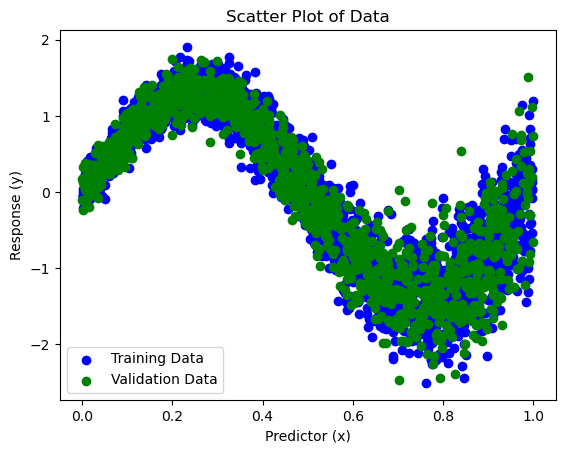

In [63]:
import matplotlib.pyplot as plt

# พล็อตกราฟการกระจายตัวของข้อมูล
plt.scatter(x_train, y_train, label='Training Data', color='blue')
plt.scatter(x_vali, y_vali, label='Validation Data', color='green')
plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.legend()
plt.title('Scatter Plot of Data')
plt.show()

# การนำเข้าและการเตรียมข้อมูล

In [77]:
import pandas as pd

# ระบุชื่อไฟล์ .csv ของชุดข้อมูล C
file_path = 'dataset-c.csv'

# โหลดข้อมูลจากไฟล์ .csv
data_a = pd.read_csv(file_path)

# แสดงตัวอย่างข้อมูล (หากต้องการ)
print(data_a.head())

          y         x
0  1.732248  0.520317
1 -1.227942  0.282942
2  0.005909  0.951035
3 -0.697223  0.389317
4 -0.977208  0.117244


In [78]:
# แบ่งชุดข้อมูลเป็นชุดการฝึกและชุดการตรวจสอบ
X = data_a[['x']].values
y = data_a['y'].values

# แบ่งชุดข้อมูลเป็นชุดการฝึก, ชุดการตรวจสอบ, และชุดทดสอบ
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)


# การใช้ Grid Search ในการค้นหาค่า p ที่เหมาะสมสำหรับ Polynomial Regression:# 

In [72]:
from sklearn.pipeline import Pipeline

# สร้างท่อการประมวลผลที่รวม PolynomialFeatures และ LinearRegression
poly_reg = PolynomialFeatures()
poly_model = LinearRegression()
poly_pipeline = Pipeline([("polynomial_features", poly_reg), ("linear_regression", poly_model)])

# กำหนดช่วงของ p ที่ต้องการทดสอบ
param_grid_poly = {'polynomial_features__degree': list(range(1, 11))}

# ใช้ GridSearchCV เพื่อค้นหาค่า p ที่เหมาะสม
grid_search_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_poly.fit(x_train, y_train)

# แสดงค่า p ที่ดีที่สุด
print("Best p for Polynomial:", grid_search_poly.best_params_['polynomial_features__degree'])

Best p for Polynomial: 1


# กำหนดช่วงของ alpha และ gamma ที่จะถูกทดสอบใน Kernel Ridge Regression

In [79]:
# กำหนดช่วงของ alpha และ gamma ที่ต้องการทดสอบ
param_grid_radial = {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# สร้างโมเดล 
radial_model = KernelRidge(kernel='rbf')

# ใช้ GridSearchCV เพื่อค้นหาค่า alpha และ gamma ที่เหมาะสม
grid_search_radial = GridSearchCV(radial_model, param_grid_radial, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_radial.fit(x_train, y_train)

# แสดงค่า alpha และ gamma ที่ดีที่สุด
print("Best alpha for Radial:", grid_search_radial.best_params_['alpha'])
print("Best gamma for Radial:", grid_search_radial.best_params_['gamma'])

Best alpha for Radial: 1000.0
Best gamma for Radial: 0.001


# # สร้างโมเดล Polynomial Regression โดยใช้ค่า p ที่ดีที่สุดที่ได้จากการทดลอง:

In [80]:
# สร้างโมเดล LBF โพลนอมิอล ด้วยค่า p ที่ดีที่สุด
best_p_poly = grid_search_poly.best_params_['polynomial_features__degree']
poly_reg = PolynomialFeatures(degree=best_p_poly)
poly_X_train = poly_reg.fit_transform(x_train)  # แก้ชื่อตัวแปรจาก X_train เป็น x_train
poly_X_val = poly_reg.transform(x_vali)  # แก้ชื่อตัวแปรจาก X_val เป็น x_vali
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_poly = poly_model.predict(poly_X_val)

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_poly = mean_squared_error(y_vali, y_val_pred_poly)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Polynomial Model:", mse_val_poly)

Validation MSE for Polynomial Model: 0.6881725686149779


# สร้างโมเดล Radial Kernel Ridge Regression โดยใช้ค่า alpha และ gamma ที่ดีที่สุดที่ได้จากการทดลอง

In [81]:
# สร้างโมเดล LBF ราเดียล ด้วยค่า alpha และ gamma ที่ดีที่สุด
best_alpha_radial = grid_search_radial.best_params_['alpha']
best_gamma_radial = grid_search_radial.best_params_['gamma']
radial_model = KernelRidge(kernel='rbf', alpha=best_alpha_radial, gamma=best_gamma_radial)
radial_model.fit(x_train, y_train)  # แก้ชื่อตัวแปร X_train เป็น x_train

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_radial = radial_model.predict(x_vali)  # แก้ชื่อตัวแปร X_val เป็น x_vali

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_radial = mean_squared_error(y_vali, y_val_pred_radial)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Radial Model:", mse_val_radial)


Validation MSE for Radial Model: 0.9954271103940205


# สร้างกราฟการกระจายตัว (Scatter Plot)

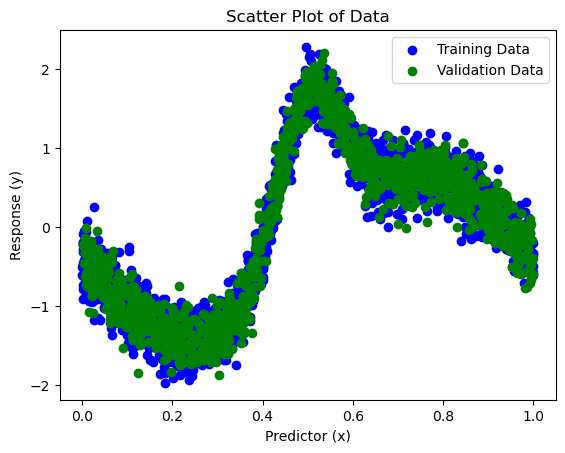

In [82]:
import matplotlib.pyplot as plt

# พล็อตกราฟการกระจายตัวของข้อมูล
plt.scatter(x_train, y_train, label='Training Data', color='blue')
plt.scatter(x_vali, y_vali, label='Validation Data', color='green')
plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.legend()
plt.title('Scatter Plot of Data')
plt.show()

# การนำเข้าและการเตรียมข้อมูล

In [87]:
import pandas as pd

# ระบุชื่อไฟล์ .csv ของชุดข้อมูล A
file_path = 'dataset-d.csv'

# โหลดข้อมูลจากไฟล์ .csv
data_a = pd.read_csv(file_path)

# แสดงตัวอย่างข้อมูล (หากต้องการ)
print(data_a.head())


          y         x
0 -1.171222  0.068870
1 -1.223282  0.061872
2  1.513045  0.987141
3  0.729461  0.941895
4 -1.177050  0.330621


In [88]:
# แบ่งชุดข้อมูลเป็นชุดการฝึกและชุดการตรวจสอบ
X = data_a[['x']].values
y = data_a['y'].values

# แบ่งชุดข้อมูลเป็นชุดการฝึก, ชุดการตรวจสอบ, และชุดทดสอบ
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)


# การใช้ Grid Search ในการค้นหาค่า p ที่เหมาะสมสำหรับ Polynomial Regression:# 

In [89]:
from sklearn.pipeline import Pipeline

# สร้างท่อการประมวลผลที่รวม PolynomialFeatures และ LinearRegression
poly_reg = PolynomialFeatures()
poly_model = LinearRegression()
poly_pipeline = Pipeline([("polynomial_features", poly_reg), ("linear_regression", poly_model)])

# กำหนดช่วงของ p ที่ต้องการทดสอบ
param_grid_poly = {'polynomial_features__degree': list(range(1, 11))}

# ใช้ GridSearchCV เพื่อค้นหาค่า p ที่เหมาะสม
grid_search_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_poly.fit(x_train, y_train)

# แสดงค่า p ที่ดีที่สุด
print("Best p for Polynomial:", grid_search_poly.best_params_['polynomial_features__degree'])

Best p for Polynomial: 1


# กำหนดช่วงของ alpha และ gamma ที่จะถูกทดสอบใน Kernel Ridge Regression

In [90]:
# กำหนดช่วงของ alpha และ gamma ที่ต้องการทดสอบ
param_grid_radial = {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# สร้างโมเดล LBF ราเดียล
radial_model = KernelRidge(kernel='rbf')

# ใช้ GridSearchCV เพื่อค้นหาค่า alpha และ gamma ที่เหมาะสม
grid_search_radial = GridSearchCV(radial_model, param_grid_radial, cv=5, scoring=make_scorer(mean_squared_error))
grid_search_radial.fit(x_train, y_train)

# แสดงค่า alpha และ gamma ที่ดีที่สุด
print("Best alpha for Radial:", grid_search_radial.best_params_['alpha'])
print("Best gamma for Radial:", grid_search_radial.best_params_['gamma'])

Best alpha for Radial: 1000.0
Best gamma for Radial: 0.001


# สร้างโมเดล Polynomial Regression โดยใช้ค่า p ที่ดีที่สุดที่ได้จากการทดลอง:

In [92]:
# สร้างโมเดล LBF โพลนอมิอล ด้วยค่า p ที่ดีที่สุด
best_p_poly = grid_search_poly.best_params_['polynomial_features__degree']
poly_reg = PolynomialFeatures(degree=best_p_poly)
poly_X_train = poly_reg.fit_transform(x_train)  # แก้ชื่อตัวแปรจาก X_train เป็น x_train
poly_X_val = poly_reg.transform(x_vali)  # แก้ชื่อตัวแปรจาก X_val เป็น x_vali
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_poly = poly_model.predict(poly_X_val)

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_poly = mean_squared_error(y_vali, y_val_pred_poly)  # แก้ชื่อตัวแปร y_val เป็น y_vali
print("Validation MSE for Polynomial Model:", mse_val_poly)

Validation MSE for Polynomial Model: 0.265396150907754


# สร้างโมเดล Radial Kernel Ridge Regression โดยใช้ค่า alpha และ gamma ที่ดีที่สุดที่ได้จากการทดลอง

In [ ]:
# สร้างโมเดล LBF ราเดียล ด้วยค่า alpha และ gamma ที่ดีที่สุด
best_alpha_radial = grid_search_radial.best_params_['alpha']
best_gamma_radial = grid_search_radial.best_params_['gamma']
radial_model = KernelRidge(kernel='rbf', alpha=best_alpha_radial, gamma=best_gamma_radial)
radial_model.fit(x_train, y_train) 

# ทดสอบโมเดลบนชุดการตรวจสอบ
y_val_pred_radial = radial_model.predict(x_vali) 

# คำนวณค่า MSE บนชุดการตรวจสอบ
mse_val_radial = mean_squared_error(y_vali, y_val_pred_radial) 
print("Validation MSE for Radial Model:", mse_val_radial)


# สร้างกราฟการกระจายตัว (Scatter Plot)

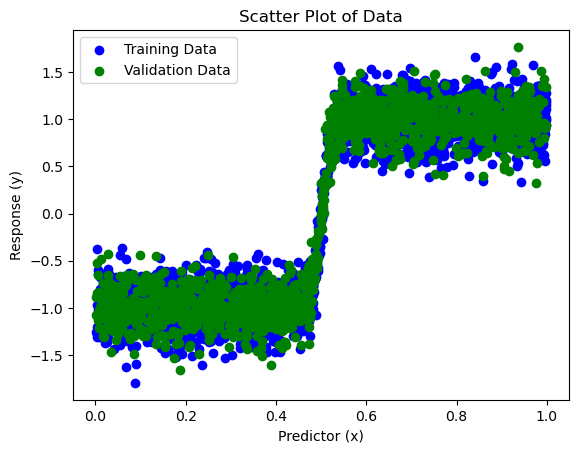

In [96]:
import matplotlib.pyplot as plt

# พล็อตกราฟการกระจายตัวของข้อมูล
plt.scatter(x_train, y_train, label='Training Data', color='blue')
plt.scatter(x_vali, y_vali, label='Validation Data', color='green')
plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.legend()
plt.title('Scatter Plot of Data')
plt.show()